In [3]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [4]:
# 데이터 로드
train_path = '/data/ephemeral/home/Bkan/Competition_dataset/train.csv'
test_path  = '/data/ephemeral/home/Bkan/Competition_dataset/test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Data shape check
train.shape, test.shape

# train set variable check!
train.info()

# train set missing value count
train.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118822 entries, 0 to 1118821
Data columns (total 52 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   시군구                     1118822 non-null  object 
 1   번지                      1118597 non-null  object 
 2   본번                      1118747 non-null  float64
 3   부번                      1118747 non-null  float64
 4   아파트명                    1116696 non-null  object 
 5   전용면적(㎡)                 1118822 non-null  float64
 6   계약년월                    1118822 non-null  int64  
 7   계약일                     1118822 non-null  int64  
 8   층                       1118822 non-null  int64  
 9   건축년도                    1118822 non-null  int64  
 10  도로명                     1118822 non-null  object 
 11  해제사유발생일                 5983 non-null     float64
 12  등기신청일자                  1118822 non-null  object 
 13  거래유형                    1118822 non-null  object 
 14  중개

시군구                             0
번지                            225
본번                             75
부번                             75
아파트명                         2126
전용면적(㎡)                         0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1112839
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         870691
k-전화번호                     870274
k-팩스번호                     872742
단지소개기존clob                1050240
k-세대타입(분양형태)               869563
k-관리방식                     869563
k-복도유형                     869890
k-난방방식                     869563
k-전체동수                     870630
k-전체세대수                    869563
k-건설사(시공사)                 871058
k-시행사                      871254
k-사용검사일-사용승인일              869696
k-연면적                      869563
k-주거전용면적      

In [5]:
# 문자열 변경을 위한 re import
import re

key_list = {}

for text in list(train.columns):
    # '전용면적별세대현황'으로 시작하면 괄호 제거 안함
    if text.startswith('k-전용면적별세대'): # 그냥 괄호를 제거하면 중복된 이름이 발생하기 때문에 처리한 예외 처리 
        cleaned = re.sub(r'^k-', '', text).strip()

    else :
        cleaned = re.sub(r'\(.*?\)','',text)
        cleaned = re.sub(r'^k-','',cleaned)
        cleaned = cleaned.strip()
    key_list[text] = cleaned
print(key_list)

train = train.rename(columns = key_list)
test = test.rename(columns = key_list)


{'시군구': '시군구', '번지': '번지', '본번': '본번', '부번': '부번', '아파트명': '아파트명', '전용면적(㎡)': '전용면적', '계약년월': '계약년월', '계약일': '계약일', '층': '층', '건축년도': '건축년도', '도로명': '도로명', '해제사유발생일': '해제사유발생일', '등기신청일자': '등기신청일자', '거래유형': '거래유형', '중개사소재지': '중개사소재지', 'k-단지분류(아파트,주상복합등등)': '단지분류', 'k-전화번호': '전화번호', 'k-팩스번호': '팩스번호', '단지소개기존clob': '단지소개기존clob', 'k-세대타입(분양형태)': '세대타입', 'k-관리방식': '관리방식', 'k-복도유형': '복도유형', 'k-난방방식': '난방방식', 'k-전체동수': '전체동수', 'k-전체세대수': '전체세대수', 'k-건설사(시공사)': '건설사', 'k-시행사': '시행사', 'k-사용검사일-사용승인일': '사용검사일-사용승인일', 'k-연면적': '연면적', 'k-주거전용면적': '주거전용면적', 'k-관리비부과면적': '관리비부과면적', 'k-전용면적별세대현황(60㎡이하)': '전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)': '전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하': '85㎡~135㎡이하', 'k-135㎡초과': '135㎡초과', 'k-홈페이지': '홈페이지', 'k-등록일자': '등록일자', 'k-수정일자': '수정일자', '고용보험관리번호': '고용보험관리번호', '경비비관리형태': '경비비관리형태', '세대전기계약방법': '세대전기계약방법', '청소비관리형태': '청소비관리형태', '건축면적': '건축면적', '주차대수': '주차대수', '기타/의무/임대/임의=1/2/3/4': '기타/의무/임대/임의=1/2/3/4', '단지승인일': '단지승인일', '사용허가여부': '사용허가여부', '관리비 업로드': '관리비 업로드

In [6]:
# Data pre-processing
## is_test : train/test 구분을 위한 변수
## concat을 통한 train, test 합쳐주기

train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])

print(concat.shape)
print(concat['is_test'].value_counts())

# concat data set variable check!
concat.info()


(1128094, 53)
0    1118822
1       9272
Name: is_test, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 53 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   시군구                   1128094 non-null  object 
 1   번지                    1127867 non-null  object 
 2   본번                    1128019 non-null  float64
 3   부번                    1128019 non-null  float64
 4   아파트명                  1125958 non-null  object 
 5   전용면적                  1128094 non-null  float64
 6   계약년월                  1128094 non-null  int64  
 7   계약일                   1128094 non-null  int64  
 8   층                     1128094 non-null  int64  
 9   건축년도                  1128094 non-null  int64  
 10  도로명                   1128094 non-null  object 
 11  해제사유발생일               6195 non-null     float64
 12  등기신청일자                1128094 non-null  object 
 13  거래유형                  

In [7]:

# concat data set missing value count & missing value ratio check! 
from wcwidth import wcswidth

# 텍스트의 '보이는 너비'를 기준으로 왼쪽 정렬하여 공백을 채워주는 함수
def pad_str(text, total_width):
    """한글, 영문, 이모지가 섞인 문자열의 보이는 너비를 계산해 정렬합니다."""
    text_width = wcswidth(str(text)) # 어떤 타입이든 문자열로 변환
    padding_size = total_width - text_width
    return str(text) + ' ' * padding_size

COL_WIDTH = 35
DTYPE_WIDTH = 25
NUNIQUE_WIDTH = 18
MISSING_WIDTH = 18


In [8]:

# header print
print(f"{pad_str('📌 컬럼명', COL_WIDTH)}| {pad_str('데이터타입', DTYPE_WIDTH)}| {pad_str('고유값', NUNIQUE_WIDTH)}| {pad_str('결측개수', MISSING_WIDTH)}| 결측률")
print("-" * (COL_WIDTH + DTYPE_WIDTH + NUNIQUE_WIDTH + MISSING_WIDTH + 20)) # 구분선


📌 컬럼명                          | 데이터타입               | 고유값            | 결측개수          | 결측률
--------------------------------------------------------------------------------------------------------------------


📌 135㎡초과                       | 데이터타입: float64      | 고유값: 2         | 결측개수: 1127765 | 99.97%
📌 해제사유발생일                  | 데이터타입: float64      | 고유값: 1034      | 결측개수: 1121899 | 99.45%
📌 등록일자                        | 데이터타입: object       | 고유값: 128       | 결측개수: 1116386 | 98.96%
📌 단지소개기존clob                | 데이터타입: float64      | 고유값: 95        | 결측개수: 1058958 | 93.87%
📌 홈페이지                        | 데이터타입: object       | 고유값: 222       | 결측개수: 1013523 | 89.84%
📌 고용보험관리번호                | 데이터타입: object       | 고유값: 527       | 결측개수: 920757  | 81.62%
📌 세대전기계약방법                | 데이터타입: object       | 고유값: 3         | 결측개수: 885389  | 78.49%
📌 팩스번호                        | 데이터타입: object       | 고유값: 1386      | 결측개수: 879348  | 77.95%
📌 시행사                          | 데이터타입: object       | 고유값: 557       | 결측개수: 877834  | 77.82%
📌 청소비관리형태                  | 데이터타입: object       | 고유값: 5         | 결측개수: 877751  | 77.81%
📌 건설사                          | 데이터타입: object       | 고유값: 345       | 결측

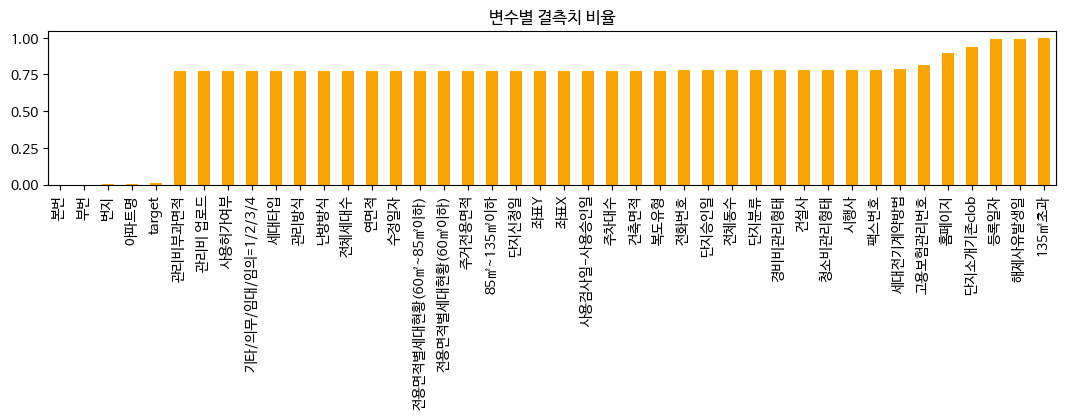

In [9]:

# 열 전체를 넣고 스캔하기
for col in concat.columns[np.argsort(concat.isnull().sum())[::-1]]:
    nunique = concat[col].nunique(dropna=False)
    missing_ratio = concat[col].isna().mean()
    missing_count = concat[col].isnull().sum()
    col_type = str(concat.dtypes[col])
    
    # 각 정보 덩어리를 pad_str 함수로 감싸 정렬합니다.
    col_str = pad_str(f"📌 {col}", COL_WIDTH)
    dtype_str = pad_str(f"데이터타입: {col_type}", DTYPE_WIDTH)
    nunique_str = pad_str(f"고유값: {nunique}", NUNIQUE_WIDTH)
    missing_str = pad_str(f"결측개수: {missing_count}", MISSING_WIDTH)

    print(f"{col_str}| {dtype_str}| {nunique_str}| {missing_str}| {missing_ratio:.2%}")

fig = plt.figure(figsize=(13, 2))
missing = concat.isnull().sum() / concat.shape[0]
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='orange')
plt.title('변수별 결측치 비율')
plt.show()


In [10]:

# 결측률이 30% 이상인 변수 삭제
print('✅  결측률이 30% 미만 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0]  < 0.3]))     # 남겨질 변수들은 아래와 같습니다.
print('❌  결측률이 30% 이상 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0] >= 0.3]))


✅  결측률이 30% 미만 변수 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', '등기신청일자', '거래유형', '중개사소재지', 'target', 'is_test']
❌  결측률이 30% 이상 변수 : ['해제사유발생일', '단지분류', '전화번호', '팩스번호', '단지소개기존clob', '세대타입', '관리방식', '복도유형', '난방방식', '전체동수', '전체세대수', '건설사', '시행사', '사용검사일-사용승인일', '연면적', '주거전용면적', '관리비부과면적', '전용면적별세대현황(60㎡이하)', '전용면적별세대현황(60㎡~85㎡이하)', '85㎡~135㎡이하', '135㎡초과', '홈페이지', '등록일자', '수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '건축면적', '주차대수', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일']


In [11]:

# 결측률 30% 이상 변수 삭제
concat.drop(columns = list(concat.columns[concat.isnull().sum()/concat.shape[0]  >= 0.3]), axis = 1, inplace = True)

In [12]:
# categorical column name, numerical column name return function
def split_categorical_numerical(df:pd.DataFrame, verbose:bool = True):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if verbose:
        print("📌 범주형 변수:", categorical_cols)
        print("📌 연속형 변수:", numerical_cols)
    return categorical_cols, numerical_cols

cat_cols, num_cols = split_categorical_numerical(concat)


📌 범주형 변수: ['시군구', '번지', '아파트명', '도로명', '등기신청일자', '거래유형', '중개사소재지']
📌 연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test']


In [13]:

# 결측치는 아닌데 의미 없는 형식적 값 찾는 함수
def detect_fake_nulls(df, suspect_values=['-', ' ', '', '.', '없음', 'nan']):
    result = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            val_counts = df[col].value_counts(dropna=False)
            found = val_counts[val_counts.index.isin(suspect_values)]
            if not found.empty:
                result[col] = found
    return result

fake_nulls = detect_fake_nulls(concat)
for col, vals in fake_nulls.items():
    print(f"🔎 {col} 컬럼에서 의미 없는 값 발견:")
    print(vals)
    print()


🔎 도로명 컬럼에서 의미 없는 값 발견:
     1211
Name: 도로명, dtype: int64

🔎 등기신청일자 컬럼에서 의미 없는 값 발견:
     1111271
Name: 등기신청일자, dtype: int64

🔎 거래유형 컬럼에서 의미 없는 값 발견:
-    1086451
Name: 거래유형, dtype: int64

🔎 중개사소재지 컬럼에서 의미 없는 값 발견:
-    1090013
Name: 중개사소재지, dtype: int64



In [14]:

# 아무 의미 없는 값 결측처리를 위해 nan으로 변경
concat['도로명'] = concat['도로명'].replace(' ', np.nan)
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)


In [15]:

# 결측률이 30% 이상인 변수 확인
print('✅  결측률이 30% 미만 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0]  < 0.3]))     # 남겨질 변수들은 아래와 같습니다.
print('❌  결측률이 30% 이상 변수 :', list(concat.columns[concat.isnull().sum()/concat.shape[0] >= 0.3]))


✅  결측률이 30% 미만 변수 : ['시군구', '번지', '본번', '부번', '아파트명', '전용면적', '계약년월', '계약일', '층', '건축년도', '도로명', 'target', 'is_test']
❌  결측률이 30% 이상 변수 : ['등기신청일자', '거래유형', '중개사소재지']


In [16]:

# 결측률 30% 이상 삭제
concat.drop(axis = 1, columns = list(concat.columns[concat.isnull().sum()/concat.shape[0] >= 0.3]), inplace=True)


In [17]:

# update and check variable
cat_cols, num_cols = split_categorical_numerical(concat)


📌 범주형 변수: ['시군구', '번지', '아파트명', '도로명']
📌 연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', '건축년도', 'target', 'is_test']


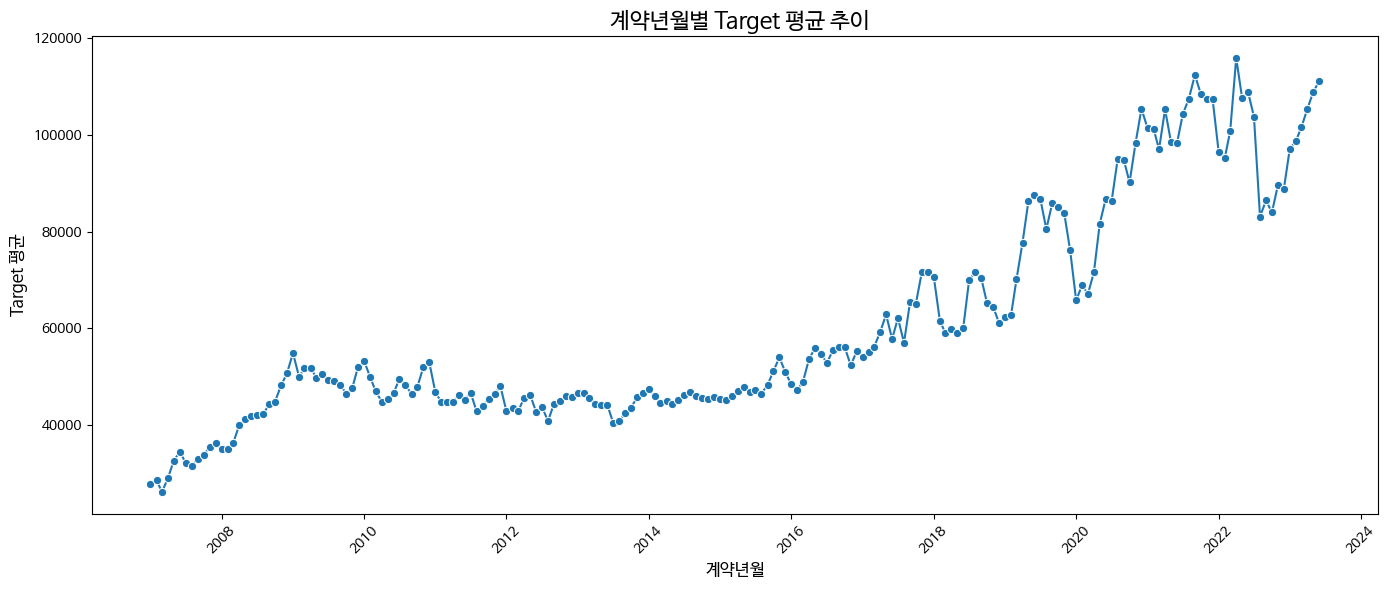

In [18]:

# 계약년월 예: 201806 
monthly_mean = concat.groupby('계약년월')['target'].mean().reset_index()
monthly_mean['계약년월'] = pd.to_datetime(monthly_mean['계약년월'].astype(str), format="%Y%m")

# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_mean, x='계약년월', y='target', marker='o')

# 제목과 라벨 꾸미기
plt.title('📈 계약년월별 Target 평균 추이', fontsize=16)
plt.xlabel('계약년월', fontsize=12)
plt.ylabel('Target 평균', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


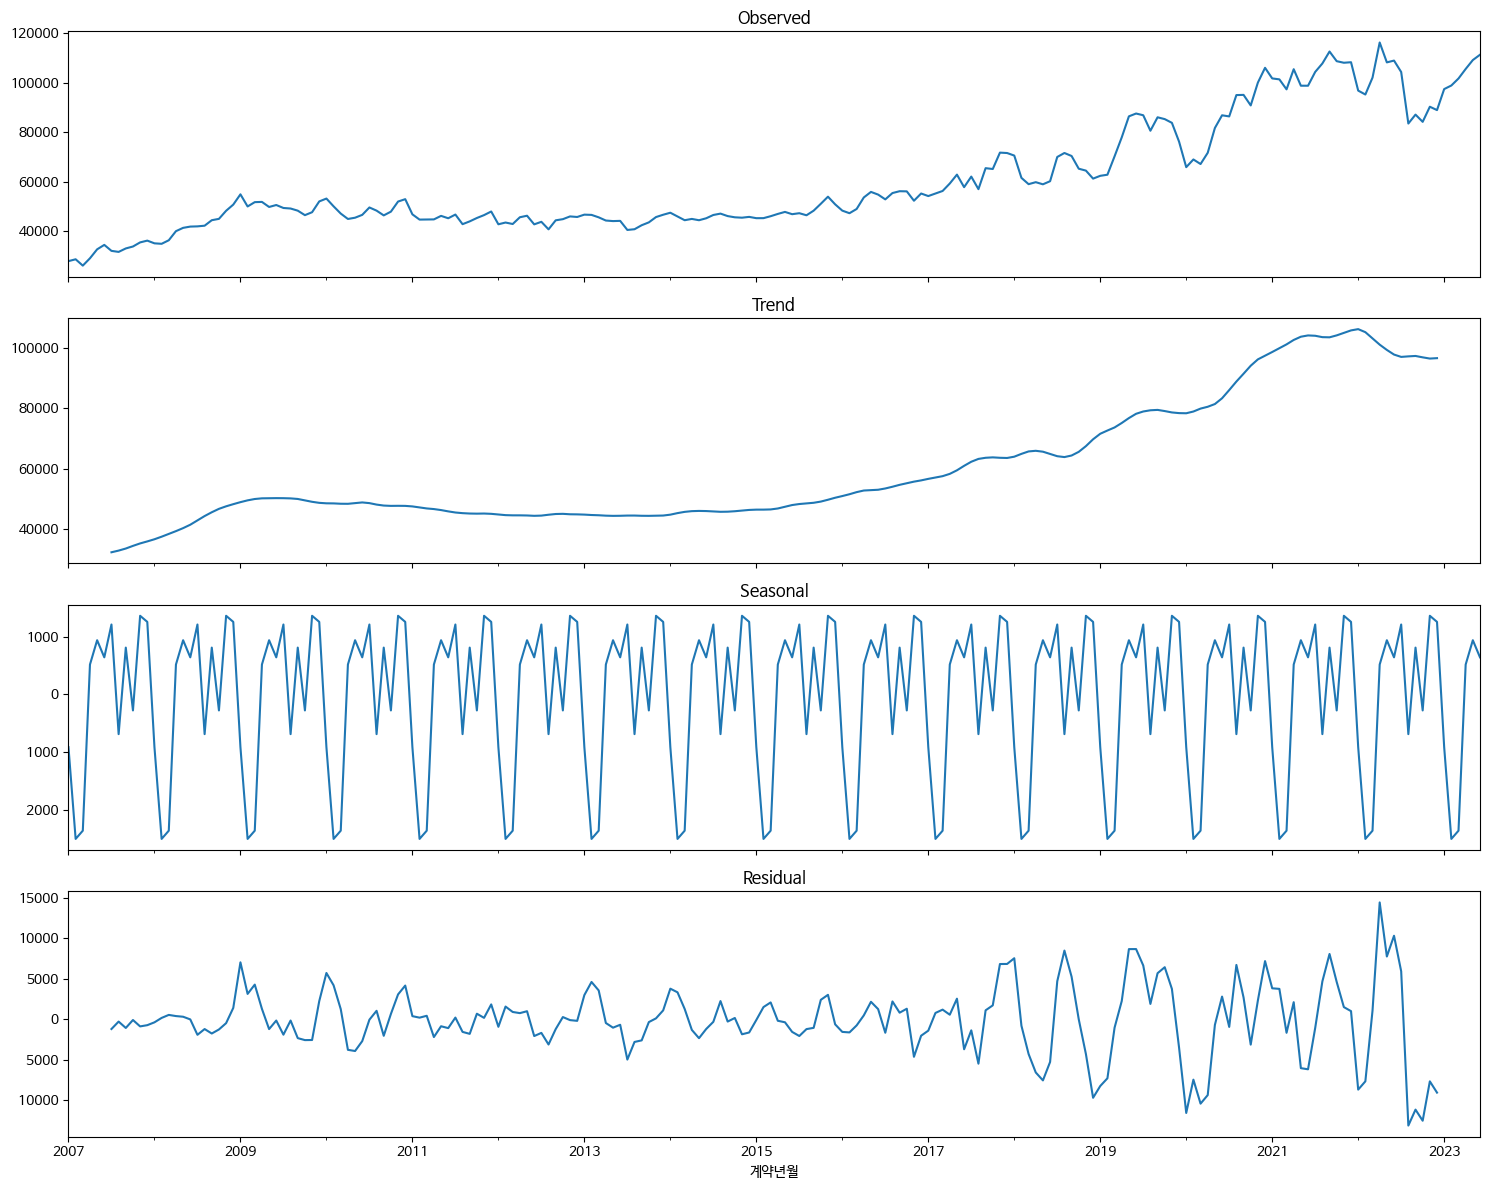

In [19]:

from statsmodels.tsa.seasonal import seasonal_decompose

monthly_mean = concat.dropna().groupby('계약년월')['target'].mean().reset_index()
monthly_mean['계약년월'] = pd.to_datetime(monthly_mean['계약년월'].astype(str), format="%Y%m")

monthly_mean_ts = monthly_mean.set_index('계약년월')['target']

decomposition = seasonal_decompose(monthly_mean_ts, model='additive', period=12);

trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid
observed = decomposition.observed

fig, axs = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

observed.plot(ax=axs[0], title='Observed')
trend.plot(ax=axs[1], title='Trend')
seasonal.plot(ax=axs[2], title='Seasonal')
resid.plot(ax=axs[3], title='Residual')

plt.tight_layout()
plt.show()


In [20]:

# 파생변수 만들기 
concat['contract_year'] = concat['계약년월'] // 100 # 계약년도
concat['contract_month'] = concat['계약년월'] % 100 # 계약월
concat['contract_date'] = concat['contract_year'] + concat['contract_month'] / 12 # 계약시간

def get_season(month):
    if month in [3,4,5]:
        return 'spring'
    elif month in [6,7,8]:
        return 'summer'
    elif month in [9,10,11]:
        return 'fall'
    else : 
        return 'winter'
concat['season'] = concat['contract_month'].apply(get_season) # 계약계절
concat['covid'] = (concat['계약년월'] >= 202001).astype(int) # 코로나 시기 구분

concat['contract_month_sin'] = np.sin(2 * np.pi * concat['contract_month'] / 12)
concat['contract_month_cos'] = np.cos(2 * np.pi * concat['contract_month'] / 12)


In [21]:

# 빌딩의 나이
current = 2025
concat['apt_age'] = current - concat['건축년도']

# 연식 구분 89년이전 old, 90년이후 new
concat['new_old'] = ['old' if 1989 >= i else 'new' for i in concat['건축년도']]

concat.drop(axis = 1, columns = ['건축년도'], inplace = True)

concat['구'] = list(map(lambda x : x.split(' ')[1],concat['시군구']))
concat['동'] = list(map(lambda x : x.split(' ')[2],concat['시군구']))


In [23]:

concat.drop(axis = 1, columns= ['시군구'], inplace = True)

# update variable list
cat_cols, num_cols = split_categorical_numerical(concat)

drop_list = ['번지', '아파트명', '도로명', '본번', '부번', '계약년월', '계약일', 'contract_year', 'contract_month']
concat.drop(axis = 1, columns= drop_list, inplace=True)

# update variable list
cat_cols, num_cols = split_categorical_numerical(concat)

concat.isnull().sum()


📌 범주형 변수: ['번지', '아파트명', '도로명', 'season', 'new_old', '구', '동']
📌 연속형 변수: ['본번', '부번', '전용면적', '계약년월', '계약일', '층', 'target', 'is_test', 'contract_year', 'contract_month', 'contract_date', 'covid', 'contract_month_sin', 'contract_month_cos', 'apt_age']
📌 범주형 변수: ['season', 'new_old', '구', '동']
📌 연속형 변수: ['전용면적', '층', 'target', 'is_test', 'contract_date', 'covid', 'contract_month_sin', 'contract_month_cos', 'apt_age']


전용면적                     0
층                        0
target                9272
is_test                  0
contract_date            0
season                   0
covid                    0
contract_month_sin       0
contract_month_cos       0
apt_age                  0
new_old                  0
구                        0
동                        0
dtype: int64

In [24]:

# train set, test set split
df_train = concat.query('is_test == 0')
df_test = concat.query('is_test == 1')

# 이제 is_test 칼럼은 drop해줍니다.
df_train.drop(['is_test'], axis = 1, inplace=True)
df_test.drop(['is_test'], axis = 1, inplace=True)
print(df_train.shape, df_test.shape)

cat_cols, num_cols = split_categorical_numerical(df_train)


(1118822, 12) (9272, 12)
📌 범주형 변수: ['season', 'new_old', '구', '동']
📌 연속형 변수: ['전용면적', '층', 'target', 'contract_date', 'covid', 'contract_month_sin', 'contract_month_cos', 'apt_age']


In [25]:

# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( cat_cols ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

df_train.head()

assert df_train.shape[1] == df_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


In [26]:

# Target과 독립변수들을 분리해줍니다.
y_train = np.log1p(df_train['target'])
X_train = df_train.drop(['target'], axis=1)

X_train.head()


,전용면적,층,contract_date,season,covid,contract_month_sin,contract_month_cos,apt_age,new_old,구,동
0,79.97,3,2018.000000,3,0,-2.449294e-16,1.000000,38,1,0,8
1,79.97,4,2018.000000,3,0,-2.449294e-16,1.000000,38,1,0,8
2,54.98,5,2018.000000,3,0,-2.449294e-16,1.000000,38,1,0,8
3,79.97,4,2018.083333,3,0,5.000000e-01,0.866025,38,1,0,8
4,79.97,2,2018.083333,3,0,5.000000e-01,0.866025,38,1,0,8


In [27]:

# =============================================================================
# LightGBM
# =============================================================================

# LightGBM import
import lightgbm as lgb
from lightgbm import LGBMRegressor

# 검증 데이터 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Train split: {X_train_split.shape}")
print(f"Validation split: {X_val_split.shape}")


Train split: (895057, 11)
Validation split: (223765, 11)


In [28]:

# LightGBM 데이터셋 생성
lgb_train = lgb.Dataset(X_train_split, y_train_split, free_raw_data=False)
lgb_valid = lgb.Dataset(X_val_split, y_val_split, reference=lgb_train, free_raw_data=False)

# LightGBM 하이퍼파라미터
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbosity': -1,
    'seed': 42,
}

print("LightGBM 모델 학습 시작...")

# 모델 학습
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    num_boost_round=2000,
    callbacks=[
        lgb.early_stopping(100),
        lgb.log_evaluation(50)
    ]
)


LightGBM 모델 학습 시작...
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.222721	valid_1's rmse: 0.223479
[100]	training's rmse: 0.175274	valid_1's rmse: 0.176083
[150]	training's rmse: 0.157313	valid_1's rmse: 0.15829
[200]	training's rmse: 0.148071	valid_1's rmse: 0.14915
[250]	training's rmse: 0.141397	valid_1's rmse: 0.142515
[300]	training's rmse: 0.136576	valid_1's rmse: 0.137826
[350]	training's rmse: 0.132509	valid_1's rmse: 0.133921
[400]	training's rmse: 0.129442	valid_1's rmse: 0.13101
[450]	training's rmse: 0.126309	valid_1's rmse: 0.128045
[500]	training's rmse: 0.124046	valid_1's rmse: 0.12591
[550]	training's rmse: 0.121836	valid_1's rmse: 0.123858
[600]	training's rmse: 0.119887	valid_1's rmse: 0.122105
[650]	training's rmse: 0.118268	valid_1's rmse: 0.120638
[700]	training's rmse: 0.116568	valid_1's rmse: 0.119084
[750]	training's rmse: 0.115148	valid_1's rmse: 0.11782
[800]	training's rmse: 0.113821	valid_1's rmse: 0.116712
[850]	train

In [29]:

# 검증 성능 확인
y_val_pred = model.predict(X_val_split, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_val_split, y_val_pred))
print(f"검증 RMSE: {rmse:.4f}")


검증 RMSE: 0.1003


In [30]:

# 테스트 데이터 예측
df_test.drop(columns=['target'], axis = 1, inplace=True)

pred = np.expm1(model.predict(df_test, num_iteration=model.best_iteration))


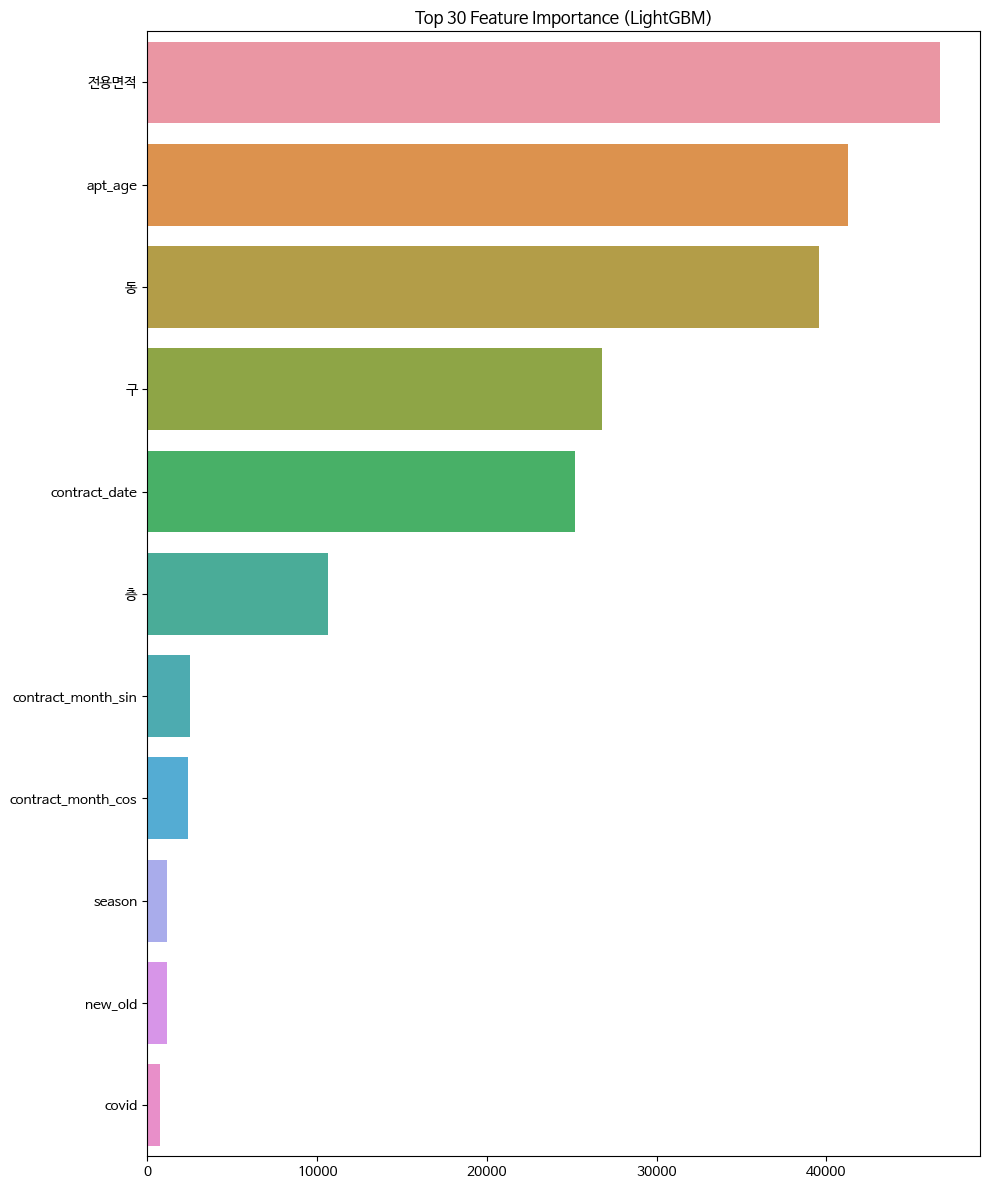

In [31]:

# Feature Importance 시각화
importances = pd.Series(model.feature_importance(), index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,12))
plt.title("Top 30 Feature Importance (LightGBM)")
sns.barplot(x=importances.head(30), y=importances.head(30).index)
plt.tight_layout()
plt.show()


In [32]:

# 학습된 모델을 저장합니다.
with open('lgbm_distance_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 예측값들을 저장합니다.
preds_df = pd.DataFrame(pred.astype(int), columns=["target"])
preds_df.to_csv('/data/ephemeral/home/Bkan/Competition_dataset/baseline_code/code/last_submission_5.csv', index=False)

print("모델 학습 및 예측 완료!")
print(f"예측값 범위: {pred.min():,.0f} ~ {pred.max():,.0f}")
print(f"예측값 평균: {pred.mean():,.0f}")

모델 학습 및 예측 완료!
예측값 범위: 8,407 ~ 1,140,095
예측값 평균: 105,776
